In [145]:
!pip install cartopy

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, Dropdown

In [ ]:
data=pd.read_csv('../data/storm_75_25.csv')
storms=pd.DataFrame(data)

In [148]:
training_storms=storms[(storms['SEASON']<2025)]

In [149]:
training_storms_name=set(training_storms['Name'])
start_lat=[]
start_lon=[]
for name in training_storms_name:
  storm_data = training_storms[training_storms['Name']==name]
  if not storm_data.empty:
    start_lat.append(storm_data.iloc[0]['LAT'])
    start_lon.append(storm_data.iloc[0]['LON'])

In [150]:
end_lat=[]
end_lon=[]
for name in training_storms_name:
  storm_data = training_storms[training_storms['Name']==name]
  if not storm_data.empty:
    end_lat.append(storm_data.iloc[-1]['LAT'])
    end_lon.append(storm_data.iloc[-1]['LON'])

In [151]:
fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon=start_lon,
    lat=start_lat,
    mode='markers',
    marker=dict(size=8, color='blue', line=dict(width=1, color='black')),
    name='Start'
))

fig.add_trace(go.Scattergeo(
    lon=end_lon,
    lat=end_lat,
    mode='markers',
    marker=dict(size=8, color='red', line=dict(width=1, color='black')),
    name='End'
))

fig.update_layout(
    title='Storm Start (Blue) and End (Red) Points',
    geo=dict(
        scope='asia',
        projection_type='equirectangular',
        showland=True,
        landcolor='rgb(230,230,230)',
        coastlinecolor='gray'
    ),
    showlegend=False  # Ẩn chú thích
)

fig.show()

In [152]:
training_storms=storms[(storms['SEASON']<2025)]
training_storms_name=set(training_storms['Name'])

/tmp/ipython-input-4080408752.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-4080408752.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



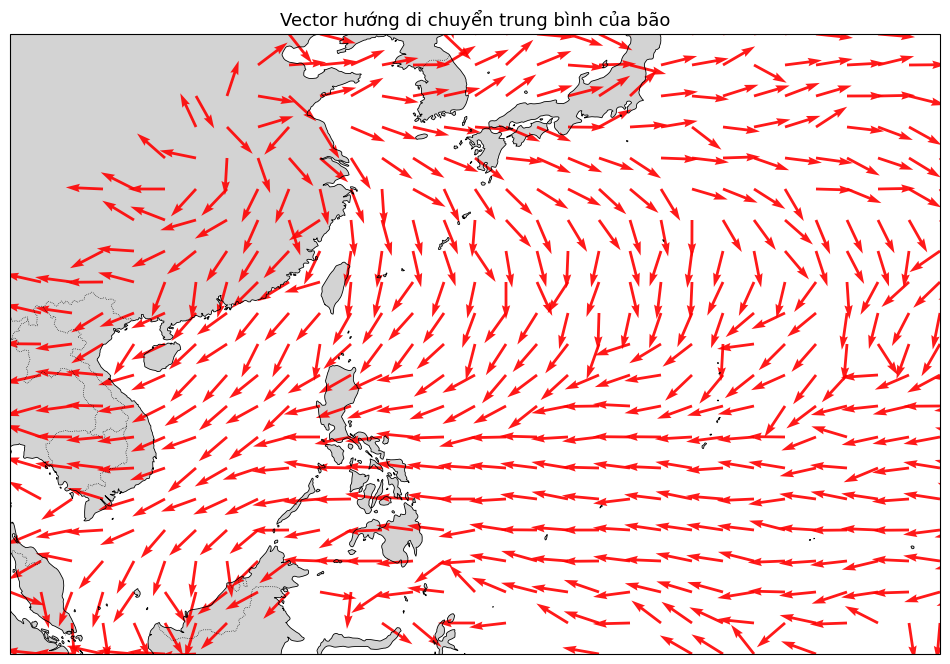

In [153]:
training_storms.loc[:, 'lat_bin'] = (training_storms['LAT'] // 2) * 2
training_storms.loc[:, 'lon_bin'] = (training_storms['LON'] // 2) * 2

dir_field = training_storms.groupby(['lat_bin', 'lon_bin'])['STORM DIR'].mean().reset_index()
dir_field.dropna(inplace=True)

fig = plt.figure(figsize=(12, 9))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([100, 160, 0, 40], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

U = np.sin(np.deg2rad(dir_field['STORM DIR']))  # Δx (kinh độ)
V = np.cos(np.deg2rad(dir_field['STORM DIR']))  # Δy (vĩ độ)

ax.quiver(
    dir_field['lon_bin'], dir_field['lat_bin'],
    U, V,
    transform=ccrs.PlateCarree(),
    color='red', scale=25, alpha=0.9, width=0.003
)

ax.set_title("Vector hướng di chuyển trung bình của bão", fontsize=13)
plt.show()

In [154]:

training_storms = training_storms.copy()
training_storms['ISO_TIME_________'] = pd.to_datetime(training_storms['ISO_TIME_________'])
training_storms['MONTH'] = training_storms['ISO_TIME_________'].dt.month

def plot_storm_vectors(month):
    plt.close('all')
    subset = training_storms[training_storms['MONTH'] == month].copy()

    if subset.empty:
        print(f"Không có dữ liệu cho tháng {month}")
        return

    subset['LAT'] = subset['LAT'].astype(float)
    subset['LON'] = subset['LON'].astype(float)

    subset['lat_bin'] = (subset['LAT'] // 2) * 2
    subset['lon_bin'] = (subset['LON'] // 2) * 2

    dir_field = subset.groupby(['lat_bin', 'lon_bin'], observed=True)['STORM DIR'].mean().reset_index()
    dir_field.dropna(inplace=True)

    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([100, 160, 0, 40], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    U = np.sin(np.deg2rad(dir_field['STORM DIR']))
    V = np.cos(np.deg2rad(dir_field['STORM DIR']))

    ax.quiver(dir_field['lon_bin'], dir_field['lat_bin'], U, V,
              transform=ccrs.PlateCarree(), color='red', scale=25, alpha=0.9, width=0.003)

    ax.set_title(f"Hướng di chuyển trung bình của bão – Tháng {month}", fontsize=13)
    plt.show()


interact(plot_storm_vectors, month=IntSlider(min=1, max=12, step=1, value=8, description='Month'))


interactive(children=(IntSlider(value=8, description='Month', max=12, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_storm_vectors(month)>

In [155]:
def plot_storm_vectors_by_season(season):
    plt.close('all')
    subset = training_storms[training_storms['SEASON'] == season].copy()

    if subset.empty:
        print(f"Không có dữ liệu cho SEASON {season}")
        return

    subset['LAT'] = subset['LAT'].astype(float)
    subset['LON'] = subset['LON'].astype(float)

    subset['lat_bin'] = (subset['LAT'] // 2) * 2
    subset['lon_bin'] = (subset['LON'] // 2) * 2

    dir_field = subset.groupby(['lat_bin', 'lon_bin'], observed=True)['STORM DIR'].mean().reset_index()
    dir_field.dropna(inplace=True)

    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([100, 160, 0, 40], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

    U = np.sin(np.deg2rad(dir_field['STORM DIR']))
    V = np.cos(np.deg2rad(dir_field['STORM DIR']))

    ax.quiver(dir_field['lon_bin'], dir_field['lat_bin'], U, V,
              transform=ccrs.PlateCarree(), color='red', scale=25, alpha=0.9, width=0.003)

    ax.set_title(f"Hướng di chuyển trung bình của bão – Mùa {season}", fontsize=13)
    plt.show()

available_seasons = sorted(training_storms['SEASON'].unique())
interact(plot_storm_vectors_by_season,
         season=IntSlider(min=min(available_seasons),
                          max=max(available_seasons),
                          step=1,
                          value=min(available_seasons),
                          description='Season'));

interactive(children=(IntSlider(value=1975, description='Season', max=2024, min=1975), Output()), _dom_classes…

In [156]:


if not np.issubdtype(storms['ISO_TIME_________'].dtype, np.datetime64):
    storms['ISO_TIME_________'] = pd.to_datetime(storms['ISO_TIME_________'], errors='coerce')

available_seasons = sorted(storms['SEASON'].unique())
available_natures = ['All'] + sorted(storms['NATURE'].dropna().unique())

def plot_direction_vectors(season, month, nature):
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_extent([90, 180, -10, 50], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='azure')
    ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)

    filtered = storms[storms['SEASON'] == season].copy()
    filtered['MONTH'] = filtered['ISO_TIME_________'].dt.month
    filtered = filtered[filtered['MONTH'] == month]
    if nature != 'All':
        filtered = filtered[filtered['NATURE'] == nature]

    if filtered.empty:
        plt.title(f'Không có dữ liệu cho Season {season}, Month {month}, Nature {nature}')
        plt.show()
        return

    filtered['lat_bin'] = (filtered['LAT'] // 2) * 2
    filtered['lon_bin'] = (filtered['LON'] // 2) * 2

    filtered['u'] = np.cos(np.deg2rad(filtered['STORM DIR']))
    filtered['v'] = np.sin(np.deg2rad(filtered['STORM DIR']))
    grouped = filtered.groupby(['lat_bin', 'lon_bin'], observed=True)[['u', 'v']].mean().reset_index()

    ax.quiver(
        grouped['lon_bin'], grouped['lat_bin'],
        grouped['u'], grouped['v'],
        scale=25, color='darkred', width=0.004, alpha=0.9,
        transform=ccrs.PlateCarree()
    )

    plt.title(f'Hướng đi trung bình – Season {season}, Month {month}, Nature {nature}', fontsize=13)
    plt.show()

interact(
    plot_direction_vectors,
    season=IntSlider(min=min(available_seasons), max=max(available_seasons), step=1, value=available_seasons[0], description='Season'),
    month=IntSlider(min=1, max=12, step=1, value=8, description='Month'),
    nature=Dropdown(options=available_natures, value='All', description='Nature')
);


interactive(children=(IntSlider(value=1975, description='Season', max=2025, min=1975), IntSlider(value=8, desc…

Sự liên quan giữa vị trí, loại bão và thời gian đối với hướng của các cơn bão